# Mount drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !ls /content/gdrive/My\ Drive

In [ ]:
# !unzip /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319/hw1_data.zip -d /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319

# Import Library

In [5]:
import os

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import json

from tqdm import tqdm
from datetime import datetime

In [6]:
import torch_geometric
from torch_geometric.data import Data, DataLoader
import torch_geometric.utils as utils

In [3]:
import networkit as nk

In [4]:
import networkx as nx

# Setting

In [7]:
class Setting:
    _root = os.getcwd()

    _data = os.path.join(_root, "hw1_data")

    data_synthetic = os.path.join(_data, "Synthetic", "5000")
    data_youtube = os.path.join(_data, "youtube")
    
    
     # Create dir for train/test
    date_time = datetime.strftime(datetime.now(), "%Y-%m-%d %H-%M")
    root = os.path.join(_root, "result", date_time)
    if os.path.exists(root):
        pass
    else:
        os.makedirs(root)


    ### Save plt info
    train_info_p = os.path.join(root, "train.json")
    val_info_p = os.path.join(root, "valid.json")
    test_info_p = os.path.join(root, "test.json")

    ### Save plt img
    result_plt_p = os.path.join(root, "train_plt.png")
    test_plt_p = os.path.join(root, "test_plt.png")
    sum_box_p = os.path.join(root, "sum_box.png")
        
        
    ### Data split
    data_split = os.path.join(_root, "split.json")
    

    # Setting of training
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    mini_epochs = 500
    epochs = 10000

    criterion = nn.BCELoss()
    weight_node2vec = os.path.join(root, "node2vec.pth")
    weight_drbc = os.path.join(root, "drbc.pth")
    
    params_drbc = None
    params_node2vec = None

    

In [8]:
setting = Setting()

# Dataset

## Data

- data.x	节点特征，维度是[num_nodes, num_node_features]。
- data.edge_index	维度是[2, num_edges]，描述图中节点的关联关系，每一列对应的两个元素，分别是边的起点和重点。数据类型是torch.long。需要注意的是，data.edge_index是定义边的节点的张量（tensor），而不是节点的列表（list）。
- data.edge_attr	边的特征矩阵，维度是[num_edges, num_edge_features]
- data.y	训练目标（维度可以是任意的）。对于节点相关的任务，维度为[num_nodes, *]；对于图相关的任务，维度为[1,*]。
- data.position	节点位置矩阵（Node position matrix），维度为[num_nodes, num_dimensions]。

- [Learning to Identify High Betweenness Centrality Nodes from
Scratch: A Novel Graph Neural Network Approach](https://arxiv.org/pdf/1905.10418.pdf)
- node initial feature = [$(d_v), 1, 1]

### Load all data

In [127]:
def load_data(path):

    edge_index = []
    between = []
    for f in os.listdir(path):
        if "score" in f:
            # ground truth of betweenness centrality
            p = os.path.join(path, f)
            between.append(p)
            pass
        else:
            p = os.path.join(path, f)
            edge_index.append(p)

    between.sort()
    edge_index.sort()
    
    return edge_index, between
    
    
synthetic, between = load_data(setting.data_synthetic)
yt, yt_score = load_data(setting.data_youtube)

### Split Data

In [128]:
from sklearn.model_selection import train_test_split


def split_data(path, x, y, replace=False):
    if os.path.exists(path) and replace:
        pass
    else:
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

        split = {
            "X_train": X_train,
            "X_valid": X_valid,
            "X_test": X_test,
            "y_train": y_train,
            "y_valid": y_valid,
            "y_test": y_test
        }

        with open(path, 'w') as f:
            json.dump(split, f)
            
split_data(path=setting.data_split, x=synthetic, y=between)

### Cvt 2 dataloader

In [129]:
def to_dataloader(x, y, batch):
    
    data_list = []
    for index, f in enumerate(x):
        edge_index = torch_geometric.io.read_txt_array(f, dtype=torch.long)
        edge_index = edge_index.t().contiguous()
        edge_index = utils.to_undirected(edge_index)

        row, col = edge_index  
        deg = utils.degree(col) # must use col to get degree, why?
        deg = deg.numpy()  

        vertice = []
        for d in deg:
            vertice.append([d, 1, 1])
        vertice = np.array(vertice, dtype=np.float)
        vertice = torch.from_numpy(vertice)

        ### between centrality
        bcs = []
        bc = torch_geometric.io.read_txt_array(y[index], dtype=torch.double)
        bc = bc.t().contiguous()
        row, col = bc
        bc = col
        bc = bc.numpy()
        
        bcs = torch.from_numpy(
                    np.array([[b] for b in bc], dtype=np.float))

        data = Data(x=vertice, edge_index=edge_index, y=bcs)
        data_list.append(data)

    loader = DataLoader(data_list, batch_size=batch)
    return data_list

### Cvt 2 Data

In [130]:
def to_data(x, y):
    edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    edge_index = utils.to_undirected(edge_index)

    row, col = edge_index  
    deg = utils.degree(col) # must use col to get degree, why?
    deg = deg.numpy()  

    vertice = []
    for d in deg:
        vertice.append([d, 1, 1])
    vertice = np.array(vertice, dtype=np.float)
    vertice = torch.from_numpy(vertice)

    ### between centrality
    bcs = []
    bc = torch_geometric.io.read_txt_array(y, dtype=torch.double)
    bc = bc.t().contiguous()
    row, col = bc
    bc = col
    bc = bc.numpy()
    bcs = torch.from_numpy(
            np.array([[b] for b in bc], dtype=np.float))

    data = Data(x=vertice, edge_index=edge_index, y=bcs)
    
    return data

#### Read data

In [131]:
f = open(setting.data_split, 'r')
data_split = json.load(f)

X_train = data_split["X_train"]
X_valid = data_split["X_valid"]
X_test = data_split["X_test"]
y_train = data_split["y_train"]
y_valid = data_split["y_valid"]
y_test = data_split["y_test"]

f.close()

#### Cvt

In [132]:
train_loader = to_dataloader(X_train, y_train, batch=1)
valid_loader = to_dataloader(X_valid, y_valid, batch=1)
test_loader = to_dataloader(X_test, y_test, batch=1)

#### Use all data

In [133]:
all_loader = to_dataloader(synthetic, between, batch=1)

#### Use YT data

In [134]:
# yt_loader = to_dataloader(yt, yt_score, batch=1)

# Model

## Hyper params

In [135]:
setting.params_drbc = dict(
    # according to source paper
    encoder_params = dict(
        c = 3,
        p = 128,
        num_layers = 5,
        device = setting.device
    ),
    decoder_params = dict(
        p = 128,
        q = 64
    )
)

# setting.params_node2vec = dict(
#     edge_index, 
#     embedding_dim, 
#     walk_length = 10, 
#     context_size,
#     p = 1,
#     q = 2
# )

## DrBC

In [136]:
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.typing import Adj, OptTensor

In [137]:
class Encoder(MessagePassing):
    def __init__(self, c, p, num_layers, device, aggr="add"):
        super(Encoder, self).__init__(aggr=aggr)
        
        self.num_layers = num_layers
        self.w_0 = nn.Linear(in_features=c, out_features=p).double()
        
        self.relu = nn.ReLU(inplace=True)
        self.rnn = nn.GRUCell(p, p).double()

        self.device = device

    def forward(self, data):
        
        x, edge_index = data.x, data.edge_index
        
        
        # compute dgree
        row, col = edge_index
        deg = utils.degree(col)
        deg = torch.add(deg, 1)
        deg_inv_sqrt = torch.pow(deg, -0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        
        # h_0 = x

        # h_1
        x = self.w_0(x)
        x = self.relu(x)
        x = F.normalize(x, p=2, dim=1)
        
        h_s = [x]
        
        for i in range(self.num_layers-1):
            # internally calls the message(), aggregate() and update() functions
            x = self.propagate(edge_index, x=x, norm=norm)
            h_s.append(x)
        
        h_s = torch.stack(h_s, dim=-1)
        # Use torch.max to replace max_pooling
        z, _ = torch.max(h_s, dim=-1)
        # z = global_max_pool(h_s, torch.tensor([0], dtype=torch.long).to(self.device))
        
        return z

    def message(self, x_j, norm: OptTensor):
        """      
        In addition, tensors passed to propagate() can be mapped to the respective nodes i and j 
        by appending _i or _j to the variable name, .e.g. x_i and x_j. 
        Note that we generally refer to i as the central nodes that aggregates information, 
        and refer to j as the neighboring nodes, since this is the most common notation.
        """
  
        return x_j if norm is None else norm.view(-1, 1) * x_j
    
    
    def update(self, aggr_out, x):
        """        
        Takes in the output of aggregation as first argument 
        and any argument which was initially passed to propagate().
        """

        x = self.rnn(x, aggr_out)
        x = F.normalize(x, p=2, dim=1) 
        
        return x
    

In [138]:
class Decoder(nn.Module):
    def __init__(self, p, q):
        
        super().__init__()
        
        self.w_4 = nn.Linear(in_features=p, out_features=q).double()
        self.w_5 = nn.Linear(in_features=q, out_features=1).double()
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, z):
        z = self.w_4(z)
        z = self.relu(z)
        z = self.w_5(z)
        
        return z

In [139]:
class DrBC(nn.Module):
    def __init__(self, encoder_params, decoder_params):
        super().__init__()
        
        self.encoder = Encoder(**encoder_params)
        self.decoder = Decoder(**decoder_params)
        
        
    def forward(self, data):
        
        z = self.encoder(data)
        
        return self.decoder(z)

## Node2Vec

In [140]:
from torch_geometric.nn import Node2Vec

In [158]:
class BC_node2vec(nn.Module):
    
    def __init__(self, node2vec_params):
        super().__init__()
        
        self.node2vec = Node2Vec(**node2vec_params)
        self.mlp = nn.Linear(in_features=128, out_features=1)
        
    def forward(self, data):
        
        x = self.node2vec(data)
        x = self.mlp(x)
        
        return x

# Load model

In [159]:
def load_checkpoint(filepath, device, **params):

    if "node2vec" in filepath:
        model = BC_node2vec(**params["node2vec"])
    
    else:
        model = DrBC(**params["drbc"])
    
    model = model.to(setting.device)
    
    if os.path.exists(filepath):
        print("pretrained finded")
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_stat'])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        optimizer.load_state_dict(checkpoint['optimizer_stat'])

    else:
        print("use a new optimizer")
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model, optimizer

# Evaluation

### Top k %

In [160]:
def top_n(model, data, k):

    with torch.no_grad():

        data = data.to(setting.device)

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))
        
        nodes = bc_gt.size()[0]
        k = int(nodes * k / 100)

        bc_pr = model(data)

        bc_gt = bc_gt.squeeze().to(setting.device)
        bc_pr = bc_pr.squeeze()

        gt_value, gt_indice = torch.topk(bc_gt, k)
        pr_value, pr_indice = torch.topk(bc_pr, k)

        gt_indice = set(gt_indice.cpu().numpy())
        pr_indice = set(pr_indice.cpu().numpy())

        intersect = len(gt_indice & pr_indice)
        top = intersect/k
            
       

        return top

### Tau Kendal

In [161]:
from scipy import stats

def tau_distance(model, data):
    
    
    with torch.no_grad():
 
        data = data.to(setting.device)

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))

        bc_pr = model(data)

        bc_gt = bc_gt.squeeze().cpu().numpy()
        bc_pr = bc_pr.squeeze().cpu().numpy()


        tau, p_value = stats.kendalltau(bc_gt, bc_pr)
       

    return tau

### Evaluation Mode

In [162]:
def eval_model(model, data):
    
    with torch.no_grad():
        data = data.to(setting.device)
        bc_pr = model(data)

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))
        
        nodes = bc_gt.size()[0]

        # random sample 5|V| nodes
        src = (torch.rand(nodes * 5) * (nodes-1)).long()
        det = (torch.rand(nodes * 5) * (nodes-1)).long()

        y_gt = (bc_gt[det] - bc_gt[src]).squeeze().to(setting.device)
        y_pr = (bc_pr[det] - bc_pr[src]).squeeze()

        y_gt = nn.Sigmoid()(y_gt)
        y_pr = nn.Sigmoid()(y_pr)

        loss = nn.BCELoss(reduction="sum")(y_pr, y_gt)
        
        return loss.item()

In [163]:
def from_networkx(G, between_list):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
    """

    G = nx.convert_node_labels_to_integers(G)
    G = G.to_directed() if not nx.is_directed(G) else G
    edge_index = torch.LongTensor(list(G.edges)).t().contiguous()
   
    data = {}

    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
           
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass

    data['edge_index'] = edge_index.view(2, -1)
    data['x'] = torch.from_numpy(
        np.array( [ [G.degree[i], 1, 1] for i in G.nodes()], dtype=np.float ) )
    data['y'] = torch.from_numpy(
        np.array( [ [b] for b in between_list ] , dtype=np.float) )
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()

    return data

# Train

In [164]:
model, optimizer = load_checkpoint(
                    setting.weight_drbc,
                    setting.device,
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)

use a new optimizer


In [165]:
nodes_cnt = 5000


model.train()

train_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):
    
    # Draw network G from distribution D (like the power-law model)
    G = nx.generators.random_graphs.powerlaw_cluster_graph(n=nodes_cnt, m=4, p=0.05)
    # Calculate each node’s exact BC value bv, ∀v ∈ V
    betweenness = nx.algorithms.centrality.betweenness_centrality(G)
    
    # Convert betweenness dict to list
    between_list = [v for k, v in sorted(betweenness.items(), key=lambda  item: int(item[0]), reverse=False)]
    
    # Convert networkx.Graph to Pyg Data
    pyg_data = from_networkx(G, between_list)
    print("\nEpoch: {}".format(epoch+1))
    
    

    
    ### Start training
    optimizer.zero_grad()

    pyg_data = pyg_data.to(setting.device)
    bc_pr = model(pyg_data)

    bc_gt = pyg_data.y
#     bc_gt = np.array(bc_gt)
#     bc_gt = torch.from_numpy(bc_gt)
    bc_gt = torch.reshape(bc_gt, (-1, ))

    # random sample 5|V| nodes
    src = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()
    det = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()

    y_gt = (bc_gt[det] - bc_gt[src]).squeeze().to(setting.device)
    y_pr = (bc_pr[det] - bc_pr[src]).squeeze()

    y_gt = nn.Sigmoid()(y_gt)
    y_pr = nn.Sigmoid()(y_pr)

    loss = nn.BCELoss(reduction="sum")(y_pr, y_gt)

    loss.backward()
    optimizer.step()
    
    
    ### Evaluation:- Train
    top1 = top_n(model, pyg_data, k=1)
    top5 = top_n(model, pyg_data, k=5)
    top10 = top_n(model, pyg_data, k=10)
    kendal = tau_distance(model, pyg_data)

    print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
            loss.item(),
            top1,
            top5,
            top10,
            kendal
    ))

    train_info["bce"].append(loss.item())
    train_info["top1"].append(top1)
    train_info["top5"].append(top5)
    train_info["top10"].append(top10)
    train_info["kendal"].append(kendal)

    with open(setting.train_info_p, 'w') as f:
        json.dump(train_info, f)



    ### Evaluation:- Synthetic
    bce_l = []
    top1_l = []
    top5_l = []
    top10_l = []
    kendal_l = []

    for data in all_loader:
        bce_l.append(eval_model(model, data))
        top1_l.append(top_n(model, data, k=1))
        top5_l.append(top_n(model, data, k=5))
        top10_l.append(top_n(model, data, k=10))
        kendal_l.append(tau_distance(model, data))
        
    bce = sum(bce_l)/len(bce_l)
    top1 = sum(top1_l)/len(top1_l)
    top5 = sum(top5_l)/len(top5_l)
    top10 = sum(top10_l)/len(top10_l)
    kendal = sum(kendal_l)/len(kendal_l)
        
    print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
        bce,
        top1,
        top5,
        top10,
        kendal
    ))

    valid_info["bce"].append(bce)
    valid_info["top1"].append(top1)
    valid_info["top5"].append(top5)
    valid_info["top10"].append(top10)
    valid_info["kendal"].append(kendal)

    with open(setting.val_info_p, 'w') as f:
        json.dump(valid_info, f)
        
    
    if top10 > top_10:
        checkpoint = {
            'model_stat': model.state_dict(),
            'optimizer_stat': optimizer.state_dict(),
        }
        torch.save(checkpoint, setting.weight_drbc)
        top_10 = top10


Epoch: 1
Train: loss = 17328.681817183424, top 1 = 0.92, top 5 = 0.84, top 10 = 0.746, kendal = 0.7468194438887777
Valid: loss = 17328.69308357833, top 1 = 0.636, top 5 = 0.6187999999999999, top 10 = 0.6415333333333334, kendal = 0.4567827058745083

Epoch: 2
Train: loss = 17328.672852006828, top 1 = 0.86, top 5 = 0.76, top 10 = 0.584, kendal = 0.6932236047209441
Valid: loss = 17328.678468844235, top 1 = 0.632, top 5 = 0.6170666666666668, top 10 = 0.6380666666666667, kendal = 0.471629451223578

Epoch: 3
Train: loss = 17328.668453861283, top 1 = 0.86, top 5 = 0.728, top 10 = 0.538, kendal = 0.5157101820364073
Valid: loss = 17328.672009743066, top 1 = 0.6326666666666667, top 5 = 0.6165333333333335, top 10 = 0.6337333333333334, kendal = 0.47577902247116083

Epoch: 4
Train: loss = 17328.66575137698, top 1 = 0.9, top 5 = 0.7, top 10 = 0.522, kendal = 0.42890930186037207
Valid: loss = 17328.668630279673, top 1 = 0.6433333333333334, top 5 = 0.6184, top 10 = 0.6296666666666668, kendal = 0.47144


Epoch: 33
Train: loss = 17328.653448325822, top 1 = 0.9, top 5 = 0.848, top 10 = 0.844, kendal = 0.4620072814562912
Valid: loss = 17328.65568434698, top 1 = 0.6533333333333332, top 5 = 0.6134666666666667, top 10 = 0.6135333333333334, kendal = 0.10557763819430553

Epoch: 34
Train: loss = 17328.64469422565, top 1 = 0.92, top 5 = 0.828, top 10 = 0.834, kendal = 0.42570546109221846
Valid: loss = 17328.65531415783, top 1 = 0.6533333333333332, top 5 = 0.6128, top 10 = 0.599, kendal = 0.06491908515036343

Epoch: 35
Train: loss = 17328.646643883847, top 1 = 0.9, top 5 = 0.832, top 10 = 0.842, kendal = 0.3996640928185637
Valid: loss = 17328.654454256175, top 1 = 0.6526666666666666, top 5 = 0.6123999999999999, top 10 = 0.5848666666666668, kendal = 0.030116770020670803

Epoch: 36
Train: loss = 17328.636434249485, top 1 = 0.9, top 5 = 0.812, top 10 = 0.824, kendal = 0.37483928785757153
Valid: loss = 17328.65516279924, top 1 = 0.6526666666666666, top 5 = 0.6120000000000001, top 10 = 0.575866666666

Valid: loss = 17328.650445909854, top 1 = 0.6526666666666667, top 5 = 0.6192000000000003, top 10 = 0.5700666666666667, kendal = -0.0009162045742481831

Epoch: 65
Train: loss = 17328.635026567772, top 1 = 0.92, top 5 = 0.852, top 10 = 0.808, kendal = 0.5988834566913384
Valid: loss = 17328.65112122398, top 1 = 0.6526666666666667, top 5 = 0.6193333333333335, top 10 = 0.5793999999999999, kendal = 0.013391312929252518

Epoch: 66
Train: loss = 17328.637849889554, top 1 = 0.94, top 5 = 0.848, top 10 = 0.84, kendal = 0.6226557311462292
Valid: loss = 17328.64951921225, top 1 = 0.6526666666666667, top 5 = 0.6193333333333333, top 10 = 0.5851333333333334, kendal = 0.025466917383476693

Epoch: 67
Train: loss = 17328.647424285806, top 1 = 0.86, top 5 = 0.864, top 10 = 0.848, kendal = 0.6228559311862373
Valid: loss = 17328.650063206605, top 1 = 0.6533333333333334, top 5 = 0.6197333333333334, top 10 = 0.5826666666666667, kendal = 0.022930767486830705

Epoch: 68
Train: loss = 17328.633303855582, top 1 


Epoch: 96
Train: loss = 17328.61727549921, top 1 = 0.88, top 5 = 0.828, top 10 = 0.83, kendal = 0.5713630726145229
Valid: loss = 17328.647993295075, top 1 = 0.6533333333333334, top 5 = 0.6198666666666668, top 10 = 0.5177333333333334, kendal = -0.08645762219110488

Epoch: 97
Train: loss = 17328.632443088798, top 1 = 0.84, top 5 = 0.824, top 10 = 0.816, kendal = 0.5506758951790358
Valid: loss = 17328.649827784575, top 1 = 0.654, top 5 = 0.6192, top 10 = 0.5006666666666667, kendal = -0.1103756324598253

Epoch: 98
Train: loss = 17328.62134168735, top 1 = 0.88, top 5 = 0.868, top 10 = 0.776, kendal = 0.4926410882176436
Valid: loss = 17328.64796650268, top 1 = 0.654, top 5 = 0.6180000000000001, top 10 = 0.48406666666666676, kendal = -0.13334729345869173

Epoch: 99
Train: loss = 17328.62901662892, top 1 = 0.92, top 5 = 0.864, top 10 = 0.78, kendal = 0.46630126025205043
Valid: loss = 17328.6479226341, top 1 = 0.654, top 5 = 0.6169333333333333, top 10 = 0.4703333333333334, kendal = -0.14880897


Epoch: 128
Train: loss = 17328.627635227444, top 1 = 0.88, top 5 = 0.848, top 10 = 0.86, kendal = 0.5797671534306862
Valid: loss = 17328.645724094138, top 1 = 0.6533333333333334, top 5 = 0.6154666666666667, top 10 = 0.4597333333333334, kendal = -0.16499992265119698

Epoch: 129
Train: loss = 17328.61687286776, top 1 = 0.88, top 5 = 0.872, top 10 = 0.832, kendal = 0.5867437487497499
Valid: loss = 17328.647467225128, top 1 = 0.6533333333333334, top 5 = 0.6177333333333332, top 10 = 0.4717333333333333, kendal = -0.15251286523971463

Epoch: 130
Train: loss = 17328.624414062575, top 1 = 0.9, top 5 = 0.88, top 10 = 0.846, kendal = 0.6012298459691939
Valid: loss = 17328.64583878086, top 1 = 0.6546666666666668, top 5 = 0.6178666666666666, top 10 = 0.4761333333333334, kendal = -0.1520206441288258

Epoch: 131
Train: loss = 17328.6287462553, top 1 = 0.88, top 5 = 0.876, top 10 = 0.846, kendal = 0.5669354670934187
Valid: loss = 17328.64578153217, top 1 = 0.6553333333333334, top 5 = 0.61306666666666

Valid: loss = 17328.646926365673, top 1 = 0.6546666666666667, top 5 = 0.58, top 10 = 0.3918, kendal = -0.22215334266853368

Epoch: 160
Train: loss = 17328.635479070756, top 1 = 0.94, top 5 = 0.864, top 10 = 0.848, kendal = 0.6356360872174435
Valid: loss = 17328.64692081934, top 1 = 0.6546666666666667, top 5 = 0.5949333333333332, top 10 = 0.4153333333333333, kendal = -0.20399115023004596

Epoch: 161
Train: loss = 17328.61445311174, top 1 = 0.9, top 5 = 0.864, top 10 = 0.874, kendal = 0.644594198839768
Valid: loss = 17328.64600051222, top 1 = 0.6546666666666667, top 5 = 0.6017333333333333, top 10 = 0.4287999999999999, kendal = -0.1927847062745882

Epoch: 162
Train: loss = 17328.627831197387, top 1 = 0.94, top 5 = 0.868, top 10 = 0.864, kendal = 0.660555471094219
Valid: loss = 17328.64455060314, top 1 = 0.6553333333333333, top 5 = 0.5954666666666666, top 10 = 0.41553333333333337, kendal = -0.2025590398079616

Epoch: 163
Train: loss = 17328.619425330864, top 1 = 0.96, top 5 = 0.872, top 10


Epoch: 191
Train: loss = 17328.631556992645, top 1 = 0.88, top 5 = 0.856, top 10 = 0.884, kendal = 0.5692628125625125
Valid: loss = 17328.649035017483, top 1 = 0.6560000000000001, top 5 = 0.5181333333333334, top 10 = 0.32399999999999995, kendal = -0.2550636473961459

Epoch: 192
Train: loss = 17328.628673386793, top 1 = 0.94, top 5 = 0.888, top 10 = 0.868, kendal = 0.5829548309661932
Valid: loss = 17328.64970599008, top 1 = 0.6560000000000001, top 5 = 0.5206666666666667, top 10 = 0.3268666666666667, kendal = -0.25116825498433015

Epoch: 193
Train: loss = 17328.632885306193, top 1 = 0.88, top 5 = 0.896, top 10 = 0.858, kendal = 0.6217990798159632
Valid: loss = 17328.645986459785, top 1 = 0.6573333333333334, top 5 = 0.5332000000000001, top 10 = 0.3368, kendal = -0.24451769820630795

Epoch: 194
Train: loss = 17328.627664924796, top 1 = 0.92, top 5 = 0.888, top 10 = 0.84, kendal = 0.6220898579715944
Valid: loss = 17328.649459394466, top 1 = 0.6573333333333334, top 5 = 0.5241333333333333, t

Valid: loss = 17328.651911966605, top 1 = 0.6533333333333334, top 5 = 0.44733333333333325, top 10 = 0.26666666666666666, kendal = -0.2761543935453758

Epoch: 223
Train: loss = 17328.611765380432, top 1 = 0.88, top 5 = 0.856, top 10 = 0.866, kendal = 0.6281603520704141
Valid: loss = 17328.651604496506, top 1 = 0.6546666666666667, top 5 = 0.4996, top 10 = 0.30393333333333333, kendal = -0.2635042528505701

Epoch: 224
Train: loss = 17328.62901912673, top 1 = 0.86, top 5 = 0.864, top 10 = 0.876, kendal = 0.6460124024804962
Valid: loss = 17328.649258097215, top 1 = 0.6553333333333333, top 5 = 0.5438666666666666, top 10 = 0.3406, kendal = -0.249837599519904

Epoch: 225
Train: loss = 17328.616904429087, top 1 = 0.92, top 5 = 0.884, top 10 = 0.866, kendal = 0.6403992798559712
Valid: loss = 17328.648426299504, top 1 = 0.6553333333333333, top 5 = 0.5476000000000002, top 10 = 0.34579999999999994, kendal = -0.24537995599119827

Epoch: 226
Train: loss = 17328.622889044324, top 1 = 0.88, top 5 = 0.88

Valid: loss = 17328.65001853891, top 1 = 0.6613333333333333, top 5 = 0.5161333333333333, top 10 = 0.3173333333333332, kendal = -0.25039254250850174

Epoch: 255
Train: loss = 17328.625561192533, top 1 = 0.84, top 5 = 0.912, top 10 = 0.886, kendal = 0.6390913382676536
Valid: loss = 17328.64979638548, top 1 = 0.6606666666666666, top 5 = 0.5125333333333334, top 10 = 0.3139333333333333, kendal = -0.2500228152297126

Epoch: 256
Train: loss = 17328.631292813523, top 1 = 0.92, top 5 = 0.872, top 10 = 0.882, kendal = 0.6037889177835567
Valid: loss = 17328.64968594557, top 1 = 0.6606666666666666, top 5 = 0.4826666666666667, top 10 = 0.2918666666666666, kendal = -0.2600393625391745

Epoch: 257
Train: loss = 17328.632775026505, top 1 = 0.92, top 5 = 0.9, top 10 = 0.878, kendal = 0.5671404680936187
Valid: loss = 17328.652598423494, top 1 = 0.6606666666666666, top 5 = 0.4593333333333333, top 10 = 0.27499999999999997, kendal = -0.2679639661265586

Epoch: 258
Train: loss = 17328.618100438835, top 1 = 

Valid: loss = 17328.65222733973, top 1 = 0.6606666666666666, top 5 = 0.5170666666666667, top 10 = 0.31873333333333326, kendal = -0.24802724278188976

Epoch: 287
Train: loss = 17328.61794592531, top 1 = 0.98, top 5 = 0.888, top 10 = 0.87, kendal = 0.664119223844769
Valid: loss = 17328.65027802395, top 1 = 0.6606666666666666, top 5 = 0.4948000000000001, top 10 = 0.3009333333333333, kendal = -0.2558386077215443

Epoch: 288
Train: loss = 17328.622974163227, top 1 = 0.9, top 5 = 0.892, top 10 = 0.856, kendal = 0.603302100420084
Valid: loss = 17328.6508315399, top 1 = 0.662, top 5 = 0.44506666666666667, top 10 = 0.2670666666666666, kendal = -0.2722475321731013

Epoch: 289
Train: loss = 17328.628159126285, top 1 = 0.9, top 5 = 0.892, top 10 = 0.852, kendal = 0.5483731946389278
Valid: loss = 17328.651127799913, top 1 = 0.6613333333333333, top 5 = 0.42546666666666666, top 10 = 0.25320000000000004, kendal = -0.27868294192171766

Epoch: 290
Train: loss = 17328.619437271613, top 1 = 0.9, top 5 = 0


Epoch: 318
Train: loss = 17328.611805405035, top 1 = 0.96, top 5 = 0.88, top 10 = 0.862, kendal = 0.5775363072614523
Valid: loss = 17328.65253211084, top 1 = 0.6606666666666666, top 5 = 0.4553333333333335, top 10 = 0.2720666666666666, kendal = -0.26553802493832096

Epoch: 319
Train: loss = 17328.63150359154, top 1 = 0.88, top 5 = 0.888, top 10 = 0.88, kendal = 0.4078122824564913
Valid: loss = 17328.65395489619, top 1 = 0.6606666666666666, top 5 = 0.4233333333333333, top 10 = 0.25060000000000004, kendal = -0.2751738294325532

Epoch: 320
Train: loss = 17328.620417600207, top 1 = 0.96, top 5 = 0.888, top 10 = 0.892, kendal = 0.6069759551910382
Valid: loss = 17328.652191187182, top 1 = 0.6606666666666666, top 5 = 0.4593333333333333, top 10 = 0.2764666666666667, kendal = -0.26128201640328064

Epoch: 321
Train: loss = 17328.63479810419, top 1 = 0.92, top 5 = 0.884, top 10 = 0.882, kendal = 0.6651936787357472
Valid: loss = 17328.65340653601, top 1 = 0.6613333333333333, top 5 = 0.4968, top 10

Valid: loss = 17328.649393302836, top 1 = 0.6606666666666666, top 5 = 0.46226666666666677, top 10 = 0.2775333333333333, kendal = -0.2656012962592519

Epoch: 350
Train: loss = 17328.622462417952, top 1 = 0.96, top 5 = 0.864, top 10 = 0.878, kendal = 0.6800670534106822
Valid: loss = 17328.650743172493, top 1 = 0.6606666666666666, top 5 = 0.4689333333333333, top 10 = 0.28193333333333326, kendal = -0.2620128559045142

Epoch: 351
Train: loss = 17328.624884101206, top 1 = 0.96, top 5 = 0.908, top 10 = 0.886, kendal = 0.6787218243648729
Valid: loss = 17328.651544882057, top 1 = 0.6606666666666666, top 5 = 0.4710666666666667, top 10 = 0.28413333333333324, kendal = -0.2597194212175769

Epoch: 352
Train: loss = 17328.623727458362, top 1 = 0.94, top 5 = 0.916, top 10 = 0.886, kendal = 0.6854497299459892
Valid: loss = 17328.6509270537, top 1 = 0.6606666666666666, top 5 = 0.48960000000000004, top 10 = 0.29786666666666667, kendal = -0.2517260625458425

Epoch: 353
Train: loss = 17328.625439547934, to


Epoch: 381
Train: loss = 17328.625416109164, top 1 = 0.9, top 5 = 0.9, top 10 = 0.866, kendal = 0.5741269853970794
Valid: loss = 17328.652188820397, top 1 = 0.6626666666666666, top 5 = 0.4369333333333334, top 10 = 0.26313333333333333, kendal = -0.27365847036073887

Epoch: 382
Train: loss = 17328.615776335762, top 1 = 0.92, top 5 = 0.876, top 10 = 0.868, kendal = 0.5270070014002801
Valid: loss = 17328.652993430398, top 1 = 0.662, top 5 = 0.4197333333333333, top 10 = 0.25013333333333343, kendal = -0.28004205641128227

Epoch: 383
Train: loss = 17328.592084703152, top 1 = 0.88, top 5 = 0.892, top 10 = 0.878, kendal = 0.6645045809161834
Valid: loss = 17328.651643568614, top 1 = 0.662, top 5 = 0.4510666666666667, top 10 = 0.27320000000000005, kendal = -0.2685529265853171

Epoch: 384
Train: loss = 17328.60984166675, top 1 = 0.92, top 5 = 0.884, top 10 = 0.872, kendal = 0.6573365873174635
Valid: loss = 17328.652805492653, top 1 = 0.662, top 5 = 0.48933333333333334, top 10 = 0.3007999999999999


Epoch: 413
Train: loss = 17328.618871689796, top 1 = 0.9, top 5 = 0.876, top 10 = 0.866, kendal = 0.4102009201840368
Valid: loss = 17328.65470699235, top 1 = 0.662, top 5 = 0.37320000000000014, top 10 = 0.2174, kendal = -0.29862949656597987

Epoch: 414
Train: loss = 17328.61764920385, top 1 = 0.92, top 5 = 0.864, top 10 = 0.872, kendal = 0.5204402480496099
Valid: loss = 17328.65217507032, top 1 = 0.6626666666666666, top 5 = 0.3842666666666668, top 10 = 0.2257333333333334, kendal = -0.29566587984263515

Epoch: 415
Train: loss = 17328.602192666338, top 1 = 0.9, top 5 = 0.884, top 10 = 0.87, kendal = 0.6645194638927786
Valid: loss = 17328.651643040306, top 1 = 0.6626666666666666, top 5 = 0.4452, top 10 = 0.26699999999999996, kendal = -0.274160677468827

Epoch: 416
Train: loss = 17328.60502250766, top 1 = 0.9, top 5 = 0.892, top 10 = 0.886, kendal = 0.643786677335467
Valid: loss = 17328.65081111201, top 1 = 0.662, top 5 = 0.48733333333333345, top 10 = 0.2983333333333333, kendal = -0.25442

Valid: loss = 17328.65389277074, top 1 = 0.6626666666666666, top 5 = 0.444, top 10 = 0.26566666666666666, kendal = -0.27145477095419085

Epoch: 445
Train: loss = 17328.614136887954, top 1 = 0.88, top 5 = 0.888, top 10 = 0.904, kendal = 0.6486698939787957
Valid: loss = 17328.655406246628, top 1 = 0.6633333333333333, top 5 = 0.42546666666666666, top 10 = 0.2524, kendal = -0.2783699406547976

Epoch: 446
Train: loss = 17328.636166007513, top 1 = 0.92, top 5 = 0.892, top 10 = 0.92, kendal = 0.6351404680936188
Valid: loss = 17328.65359921063, top 1 = 0.6633333333333333, top 5 = 0.4094666666666667, top 10 = 0.24273333333333333, kendal = -0.28299148896445947

Epoch: 447
Train: loss = 17328.632928595176, top 1 = 0.94, top 5 = 0.908, top 10 = 0.896, kendal = 0.6597917983596719
Valid: loss = 17328.65225532725, top 1 = 0.6633333333333333, top 5 = 0.42813333333333337, top 10 = 0.2546666666666667, kendal = -0.27442180702807234

Epoch: 448
Train: loss = 17328.614810089974, top 1 = 0.94, top 5 = 0.9, 


Epoch: 476
Train: loss = 17328.621512695405, top 1 = 0.88, top 5 = 0.872, top 10 = 0.902, kendal = 0.6613877975595119
Valid: loss = 17328.653653627207, top 1 = 0.6646666666666666, top 5 = 0.4393333333333334, top 10 = 0.2647333333333333, kendal = -0.27003694605587786

Epoch: 477
Train: loss = 17328.611956278968, top 1 = 0.92, top 5 = 0.884, top 10 = 0.882, kendal = 0.683697699539908
Valid: loss = 17328.650778360578, top 1 = 0.6633333333333333, top 5 = 0.43760000000000004, top 10 = 0.26306666666666667, kendal = -0.2684725638461025

Epoch: 478
Train: loss = 17328.622501976868, top 1 = 0.88, top 5 = 0.92, top 10 = 0.894, kendal = 0.6673265853170635
Valid: loss = 17328.652026012667, top 1 = 0.6639999999999999, top 5 = 0.4376, top 10 = 0.26333333333333336, kendal = -0.26603228912449156

Epoch: 479
Train: loss = 17328.619657724856, top 1 = 0.96, top 5 = 0.892, top 10 = 0.892, kendal = 0.6319793558711743
Valid: loss = 17328.651747000124, top 1 = 0.6639999999999999, top 5 = 0.42266666666666663

Valid: loss = 17328.65430212756, top 1 = 0.6639999999999999, top 5 = 0.3881333333333334, top 10 = 0.22920000000000004, kendal = -0.29380936453957457

Epoch: 508
Train: loss = 17328.623418634346, top 1 = 0.94, top 5 = 0.904, top 10 = 0.9, kendal = 0.6253266653330666
Valid: loss = 17328.652807325136, top 1 = 0.6633333333333333, top 5 = 0.43293333333333345, top 10 = 0.2594, kendal = -0.2735247156097887

Epoch: 509
Train: loss = 17328.63555448921, top 1 = 0.9, top 5 = 0.876, top 10 = 0.9, kendal = 0.6081856371274255
Valid: loss = 17328.65160931862, top 1 = 0.6626666666666666, top 5 = 0.4750666666666667, top 10 = 0.2944666666666666, kendal = -0.2454671574314863

Epoch: 510
Train: loss = 17328.623264088477, top 1 = 0.96, top 5 = 0.876, top 10 = 0.892, kendal = 0.618775275055011
Valid: loss = 17328.651633650254, top 1 = 0.6626666666666666, top 5 = 0.44466666666666665, top 10 = 0.2702, kendal = -0.25482495965859836

Epoch: 511
Train: loss = 17328.628574418963, top 1 = 0.92, top 5 = 0.904, top 


Epoch: 539
Train: loss = 17328.590956786895, top 1 = 0.9, top 5 = 0.88, top 10 = 0.898, kendal = 0.6381813962792559
Valid: loss = 17328.653343223883, top 1 = 0.6639999999999999, top 5 = 0.43106666666666676, top 10 = 0.2579333333333333, kendal = -0.2628166326598652

Epoch: 540
Train: loss = 17328.61060484011, top 1 = 0.94, top 5 = 0.888, top 10 = 0.882, kendal = 0.4439115023004601
Valid: loss = 17328.654087341427, top 1 = 0.6639999999999999, top 5 = 0.40360000000000007, top 10 = 0.2412, kendal = -0.2706533039941322

Epoch: 541
Train: loss = 17328.621858232334, top 1 = 0.88, top 5 = 0.884, top 10 = 0.89, kendal = 0.5904777755551109
Valid: loss = 17328.65210287253, top 1 = 0.6646666666666666, top 5 = 0.44466666666666665, top 10 = 0.26946666666666663, kendal = -0.2530008988464359

Epoch: 542
Train: loss = 17328.620722240295, top 1 = 0.92, top 5 = 0.888, top 10 = 0.86, kendal = 0.7313035407081416
Valid: loss = 17328.651839748152, top 1 = 0.6646666666666666, top 5 = 0.47426666666666667, top

Valid: loss = 17328.649736858024, top 1 = 0.6646666666666666, top 5 = 0.41173333333333334, top 10 = 0.2460666666666667, kendal = -0.2771239314529573

Epoch: 571
Train: loss = 17328.63021049156, top 1 = 0.9, top 5 = 0.92, top 10 = 0.916, kendal = 0.649529425885177
Valid: loss = 17328.651536124882, top 1 = 0.6646666666666666, top 5 = 0.4577333333333333, top 10 = 0.2806666666666666, kendal = -0.2495120357404814

Epoch: 572
Train: loss = 17328.632216072343, top 1 = 0.92, top 5 = 0.888, top 10 = 0.896, kendal = 0.6824329665933188
Valid: loss = 17328.6520817884, top 1 = 0.6646666666666666, top 5 = 0.47506666666666664, top 10 = 0.29513333333333325, kendal = -0.23505627525505102

Epoch: 573
Train: loss = 17328.62051308218, top 1 = 0.94, top 5 = 0.9, top 10 = 0.876, kendal = 0.6349261852370475
Valid: loss = 17328.654573053776, top 1 = 0.6646666666666666, top 5 = 0.4249333333333334, top 10 = 0.2543333333333333, kendal = -0.2596306194572248

Epoch: 574
Train: loss = 17328.61420729915, top 1 = 0.9

Valid: loss = 17328.653936970702, top 1 = 0.6653333333333332, top 5 = 0.4841333333333334, top 10 = 0.2974666666666666, kendal = -0.24222693605387743

Epoch: 602
Train: loss = 17328.624275452865, top 1 = 0.96, top 5 = 0.892, top 10 = 0.902, kendal = 0.7177526705341069
Valid: loss = 17328.653210724526, top 1 = 0.6653333333333332, top 5 = 0.4537333333333333, top 10 = 0.2733333333333334, kendal = -0.25693036207241454

Epoch: 603
Train: loss = 17328.617431085222, top 1 = 0.94, top 5 = 0.876, top 10 = 0.878, kendal = 0.5703006201240248
Valid: loss = 17328.655727546677, top 1 = 0.6646666666666666, top 5 = 0.4032000000000001, top 10 = 0.23986666666666664, kendal = -0.2781446049209842

Epoch: 604
Train: loss = 17328.62206374964, top 1 = 0.96, top 5 = 0.912, top 10 = 0.874, kendal = 0.4980327265453091
Valid: loss = 17328.654274457298, top 1 = 0.6639999999999999, top 5 = 0.3776, top 10 = 0.2206666666666667, kendal = -0.2891468320330734

Epoch: 605
Train: loss = 17328.62536822843, top 1 = 0.96, to

Valid: loss = 17328.65277384999, top 1 = 0.6666666666666665, top 5 = 0.4557333333333334, top 10 = 0.2756, kendal = -0.24868567846902714

Epoch: 633
Train: loss = 17328.632506321486, top 1 = 0.96, top 5 = 0.888, top 10 = 0.898, kendal = 0.673564472894579
Valid: loss = 17328.65383313462, top 1 = 0.6673333333333332, top 5 = 0.4510666666666668, top 10 = 0.2707333333333333, kendal = -0.25252182703207304

Epoch: 634
Train: loss = 17328.625812602302, top 1 = 0.94, top 5 = 0.896, top 10 = 0.89, kendal = 0.6584280056011202
Valid: loss = 17328.652387389167, top 1 = 0.6659999999999999, top 5 = 0.4318666666666669, top 10 = 0.2570666666666666, kendal = -0.2622285737147429

Epoch: 635
Train: loss = 17328.589657088272, top 1 = 0.9, top 5 = 0.896, top 10 = 0.88, kendal = 0.6408185637127425
Valid: loss = 17328.653567053072, top 1 = 0.6659999999999999, top 5 = 0.4104, top 10 = 0.2432, kendal = -0.27233673401346936

Epoch: 636
Train: loss = 17328.62275977731, top 1 = 0.92, top 5 = 0.912, top 10 = 0.896, 


Epoch: 664
Train: loss = 17328.62626718564, top 1 = 0.94, top 5 = 0.892, top 10 = 0.892, kendal = 0.6271220644128827
Valid: loss = 17328.653993802014, top 1 = 0.6679999999999998, top 5 = 0.4454666666666667, top 10 = 0.26813333333333333, kendal = -0.2612006294592252

Epoch: 665
Train: loss = 17328.611800342027, top 1 = 0.96, top 5 = 0.888, top 10 = 0.904, kendal = 0.6245509901980397
Valid: loss = 17328.655512714864, top 1 = 0.6673333333333332, top 5 = 0.45080000000000015, top 10 = 0.2714666666666667, kendal = -0.2627974394878977

Epoch: 666
Train: loss = 17328.634408458845, top 1 = 0.94, top 5 = 0.904, top 10 = 0.88, kendal = 0.5936068813762753
Valid: loss = 17328.65420307107, top 1 = 0.6679999999999998, top 5 = 0.44160000000000005, top 10 = 0.2656, kendal = -0.2684601133560045

Epoch: 667
Train: loss = 17328.617402182303, top 1 = 0.92, top 5 = 0.916, top 10 = 0.892, kendal = 0.6168699339867973
Valid: loss = 17328.65359197996, top 1 = 0.6679999999999998, top 5 = 0.4538666666666667, top

Train: loss = 17328.632510357544, top 1 = 0.96, top 5 = 0.904, top 10 = 0.91, kendal = 0.7102015603120624
Valid: loss = 17328.65285396295, top 1 = 0.6666666666666665, top 5 = 0.4376, top 10 = 0.26406666666666667, kendal = -0.25696240048009605

Epoch: 696
Train: loss = 17328.61718517371, top 1 = 0.94, top 5 = 0.924, top 10 = 0.912, kendal = 0.6742700540108022
Valid: loss = 17328.652526329715, top 1 = 0.6673333333333332, top 5 = 0.4550666666666666, top 10 = 0.27726666666666666, kendal = -0.24997417083416684

Epoch: 697
Train: loss = 17328.62775802002, top 1 = 0.94, top 5 = 0.88, top 10 = 0.918, kendal = 0.6881341068213642
Valid: loss = 17328.65397573192, top 1 = 0.6673333333333332, top 5 = 0.44120000000000004, top 10 = 0.266, kendal = -0.25663175301727015

Epoch: 698
Train: loss = 17328.624045375684, top 1 = 0.9, top 5 = 0.904, top 10 = 0.886, kendal = 0.50414274854971
Valid: loss = 17328.656518991582, top 1 = 0.6679999999999998, top 5 = 0.38213333333333327, top 10 = 0.22586666666666666,

Valid: loss = 17328.650420766906, top 1 = 0.6659999999999999, top 5 = 0.5166666666666666, top 10 = 0.32666666666666655, kendal = -0.19667809295192368

Epoch: 727
Train: loss = 17328.63930953283, top 1 = 0.92, top 5 = 0.908, top 10 = 0.928, kendal = 0.695515903180636
Valid: loss = 17328.653695044977, top 1 = 0.6659999999999999, top 5 = 0.4906666666666666, top 10 = 0.3063333333333333, kendal = -0.21635406547976263

Epoch: 728
Train: loss = 17328.64140426158, top 1 = 0.94, top 5 = 0.92, top 10 = 0.91, kendal = 0.656667973594719
Valid: loss = 17328.654854688048, top 1 = 0.6693333333333331, top 5 = 0.4242666666666668, top 10 = 0.2524666666666666, kendal = -0.25909747282789897

Epoch: 729
Train: loss = 17328.60578349348, top 1 = 0.88, top 5 = 0.916, top 10 = 0.828, kendal = 0.25616755351070214
Valid: loss = 17328.65668831377, top 1 = 0.6686666666666665, top 5 = 0.3637333333333333, top 10 = 0.21240000000000003, kendal = -0.2870810962192438

Epoch: 730
Train: loss = 17328.614241969426, top 1 =


Epoch: 758
Train: loss = 17328.61862592004, top 1 = 0.92, top 5 = 0.896, top 10 = 0.9, kendal = 0.706568673734747
Valid: loss = 17328.652778588243, top 1 = 0.6693333333333331, top 5 = 0.42666666666666664, top 10 = 0.255, kendal = -0.26064072014402884

Epoch: 759
Train: loss = 17328.6345847235, top 1 = 0.92, top 5 = 0.896, top 10 = 0.898, kendal = 0.6448592118423685
Valid: loss = 17328.65341830697, top 1 = 0.6686666666666665, top 5 = 0.4009333333333334, top 10 = 0.23893333333333336, kendal = -0.27107295059011804

Epoch: 760
Train: loss = 17328.61953052765, top 1 = 0.9, top 5 = 0.876, top 10 = 0.894, kendal = 0.6282707741548309
Valid: loss = 17328.65307907895, top 1 = 0.6686666666666665, top 5 = 0.40026666666666677, top 10 = 0.23879999999999998, kendal = -0.27116798826431954

Epoch: 761
Train: loss = 17328.618711694187, top 1 = 0.92, top 5 = 0.892, top 10 = 0.892, kendal = 0.7189501900380076
Valid: loss = 17328.652340688815, top 1 = 0.6693333333333331, top 5 = 0.43413333333333337, top 1

Valid: loss = 17328.65476931666, top 1 = 0.6686666666666665, top 5 = 0.40520000000000006, top 10 = 0.24280000000000002, kendal = -0.2615940521437621

Epoch: 790
Train: loss = 17328.639984934925, top 1 = 0.96, top 5 = 0.916, top 10 = 0.92, kendal = 0.6159462292458492
Valid: loss = 17328.65593751391, top 1 = 0.6686666666666665, top 5 = 0.4004, top 10 = 0.2414000000000001, kendal = -0.25898925918517035

Epoch: 791
Train: loss = 17328.620522192847, top 1 = 0.94, top 5 = 0.884, top 10 = 0.914, kendal = 0.6653332266453291
Valid: loss = 17328.653944757232, top 1 = 0.6686666666666665, top 5 = 0.41813333333333347, top 10 = 0.2521333333333333, kendal = -0.24844441955057675

Epoch: 792
Train: loss = 17328.62618720668, top 1 = 0.94, top 5 = 0.932, top 10 = 0.912, kendal = 0.7167580716143229
Valid: loss = 17328.65469309043, top 1 = 0.6686666666666665, top 5 = 0.42826666666666663, top 10 = 0.25893333333333335, kendal = -0.24307863706074548

Epoch: 793
Train: loss = 17328.597308620974, top 1 = 0.98, 

Valid: loss = 17328.6532909098, top 1 = 0.6686666666666665, top 5 = 0.39306666666666656, top 10 = 0.23393333333333333, kendal = -0.2594195105687804

Epoch: 821
Train: loss = 17328.63097989092, top 1 = 0.9, top 5 = 0.908, top 10 = 0.916, kendal = 0.7158066813362672
Valid: loss = 17328.65256436224, top 1 = 0.6686666666666665, top 5 = 0.42200000000000004, top 10 = 0.25193333333333334, kendal = -0.24826023338000933

Epoch: 822
Train: loss = 17328.63122009397, top 1 = 0.92, top 5 = 0.9, top 10 = 0.916, kendal = 0.6973831566313262
Valid: loss = 17328.651543238837, top 1 = 0.6686666666666665, top 5 = 0.4641333333333334, top 10 = 0.2834, kendal = -0.22681947589517906

Epoch: 823
Train: loss = 17328.628612066314, top 1 = 0.92, top 5 = 0.912, top 10 = 0.9, kendal = 0.6961659531906381
Valid: loss = 17328.65184841368, top 1 = 0.6693333333333331, top 5 = 0.4664, top 10 = 0.2853333333333332, kendal = -0.22639113956124565

Epoch: 824
Train: loss = 17328.616325561878, top 1 = 0.96, top 5 = 0.916, top 

Valid: loss = 17328.65133012372, top 1 = 0.6693333333333331, top 5 = 0.4470666666666668, top 10 = 0.27706666666666663, kendal = -0.23398309528572375

Epoch: 852
Train: loss = 17328.613104822027, top 1 = 0.94, top 5 = 0.912, top 10 = 0.906, kendal = 0.6036668133626726
Valid: loss = 17328.652993489737, top 1 = 0.6693333333333331, top 5 = 0.40040000000000003, top 10 = 0.24273333333333338, kendal = -0.2642267813562713

Epoch: 853
Train: loss = 17328.62670985644, top 1 = 0.96, top 5 = 0.916, top 10 = 0.872, kendal = 0.3995683936787358
Valid: loss = 17328.654759641893, top 1 = 0.6699999999999998, top 5 = 0.37360000000000004, top 10 = 0.22073333333333336, kendal = -0.28051407081416285

Epoch: 854
Train: loss = 17328.618373472178, top 1 = 0.94, top 5 = 0.9, top 10 = 0.882, kendal = 0.5041281856371275
Valid: loss = 17328.653868362646, top 1 = 0.6693333333333331, top 5 = 0.39386666666666664, top 10 = 0.23600000000000002, kendal = -0.27505022604520907

Epoch: 855
Train: loss = 17328.63637032164, 


Epoch: 883
Train: loss = 17328.621064725878, top 1 = 0.92, top 5 = 0.9, top 10 = 0.874, kendal = 0.705171274254851
Valid: loss = 17328.653420823353, top 1 = 0.6699999999999998, top 5 = 0.44426666666666675, top 10 = 0.2729333333333333, kendal = -0.23291945855837828

Epoch: 884
Train: loss = 17328.607584371995, top 1 = 0.92, top 5 = 0.876, top 10 = 0.914, kendal = 0.7103769553910783
Valid: loss = 17328.654008017733, top 1 = 0.6693333333333331, top 5 = 0.4215999999999999, top 10 = 0.25520000000000004, kendal = -0.24865816363272655

Epoch: 885
Train: loss = 17328.624281216504, top 1 = 0.94, top 5 = 0.888, top 10 = 0.888, kendal = 0.5694206041208242
Valid: loss = 17328.65538373276, top 1 = 0.6693333333333331, top 5 = 0.3822666666666668, top 10 = 0.22973333333333337, kendal = -0.2695883603387344

Epoch: 886
Train: loss = 17328.613130489517, top 1 = 0.96, top 5 = 0.908, top 10 = 0.868, kendal = 0.4525501900380076
Valid: loss = 17328.655723608153, top 1 = 0.6693333333333331, top 5 = 0.3614666


Epoch: 914
Train: loss = 17328.61656997042, top 1 = 0.98, top 5 = 0.888, top 10 = 0.918, kendal = 0.723097899579916
Valid: loss = 17328.653908880264, top 1 = 0.6693333333333331, top 5 = 0.41000000000000003, top 10 = 0.24866666666666673, kendal = -0.24988635593785433

Epoch: 915
Train: loss = 17328.63463563221, top 1 = 0.9, top 5 = 0.904, top 10 = 0.91, kendal = 0.6818203640728145
Valid: loss = 17328.654560234645, top 1 = 0.6693333333333331, top 5 = 0.3888, top 10 = 0.23520000000000002, kendal = -0.2554354817630193

Epoch: 916
Train: loss = 17328.6309394962, top 1 = 0.98, top 5 = 0.928, top 10 = 0.91, kendal = 0.662920424084817
Valid: loss = 17328.652598471723, top 1 = 0.6693333333333331, top 5 = 0.3914666666666667, top 10 = 0.23766666666666672, kendal = -0.25199207841568316

Epoch: 917
Train: loss = 17328.62279107597, top 1 = 0.94, top 5 = 0.892, top 10 = 0.898, kendal = 0.713992398479696
Valid: loss = 17328.652125449044, top 1 = 0.6693333333333331, top 5 = 0.4097333333333334, top 10 

Valid: loss = 17328.654381905777, top 1 = 0.6699999999999998, top 5 = 0.3669333333333334, top 10 = 0.21653333333333344, kendal = -0.26148500633460026

Epoch: 946
Train: loss = 17328.62503452425, top 1 = 0.86, top 5 = 0.928, top 10 = 0.908, kendal = 0.7190494098819764
Valid: loss = 17328.653323777806, top 1 = 0.6699999999999998, top 5 = 0.41893333333333344, top 10 = 0.25220000000000004, kendal = -0.2319974234846969

Epoch: 947
Train: loss = 17328.631585864154, top 1 = 0.92, top 5 = 0.904, top 10 = 0.906, kendal = 0.6684263252650531
Valid: loss = 17328.65172019914, top 1 = 0.6699999999999998, top 5 = 0.4513333333333333, top 10 = 0.2752, kendal = -0.21260824964993

Epoch: 948
Train: loss = 17328.627048603157, top 1 = 0.9, top 5 = 0.896, top 10 = 0.91, kendal = 0.6754066013202641
Valid: loss = 17328.65154752884, top 1 = 0.6699999999999998, top 5 = 0.45119999999999993, top 10 = 0.2750666666666667, kendal = -0.2115210295392412

Epoch: 949
Train: loss = 17328.630241744773, top 1 = 0.92, top 5


Epoch: 977
Train: loss = 17328.617888306304, top 1 = 0.94, top 5 = 0.916, top 10 = 0.892, kendal = 0.7045159431886377
Valid: loss = 17328.65436565374, top 1 = 0.6699999999999998, top 5 = 0.37826666666666675, top 10 = 0.2224666666666667, kendal = -0.2532957844902313

Epoch: 978
Train: loss = 17328.620836097296, top 1 = 0.92, top 5 = 0.92, top 10 = 0.916, kendal = 0.6943015803160633
Valid: loss = 17328.652067739495, top 1 = 0.6699999999999998, top 5 = 0.4041333333333333, top 10 = 0.24146666666666675, kendal = -0.23942028405681137

Epoch: 979
Train: loss = 17328.619306070163, top 1 = 0.94, top 5 = 0.9, top 10 = 0.9, kendal = 0.684269173834767
Valid: loss = 17328.652435128486, top 1 = 0.6699999999999998, top 5 = 0.4217333333333333, top 10 = 0.25306666666666666, kendal = -0.22967869840634797

Epoch: 980
Train: loss = 17328.62809802784, top 1 = 0.92, top 5 = 0.908, top 10 = 0.894, kendal = 0.729300100020004
Valid: loss = 17328.65227063919, top 1 = 0.6699999999999998, top 5 = 0.4096000000000


Epoch: 1008
Train: loss = 17328.618752672628, top 1 = 1.0, top 5 = 0.92, top 10 = 0.902, kendal = 0.7307762352470494
Valid: loss = 17328.65265849802, top 1 = 0.6699999999999998, top 5 = 0.40146666666666664, top 10 = 0.24213333333333337, kendal = -0.2438302913916116

Epoch: 1009
Train: loss = 17328.617336123774, top 1 = 0.92, top 5 = 0.924, top 10 = 0.906, kendal = 0.6969608321664332
Valid: loss = 17328.653929300242, top 1 = 0.6699999999999998, top 5 = 0.3874666666666667, top 10 = 0.234, kendal = -0.24945456824698276

Epoch: 1010
Train: loss = 17328.635462050323, top 1 = 0.94, top 5 = 0.932, top 10 = 0.922, kendal = 0.7262471694338868
Valid: loss = 17328.65421761292, top 1 = 0.6699999999999998, top 5 = 0.41253333333333336, top 10 = 0.2489333333333334, kendal = -0.23817609388544383

Epoch: 1011
Train: loss = 17328.618900873847, top 1 = 0.92, top 5 = 0.908, top 10 = 0.904, kendal = 0.7387755951190238
Valid: loss = 17328.65195555054, top 1 = 0.6706666666666664, top 5 = 0.44039999999999996

KeyboardInterrupt: 

# Visualization

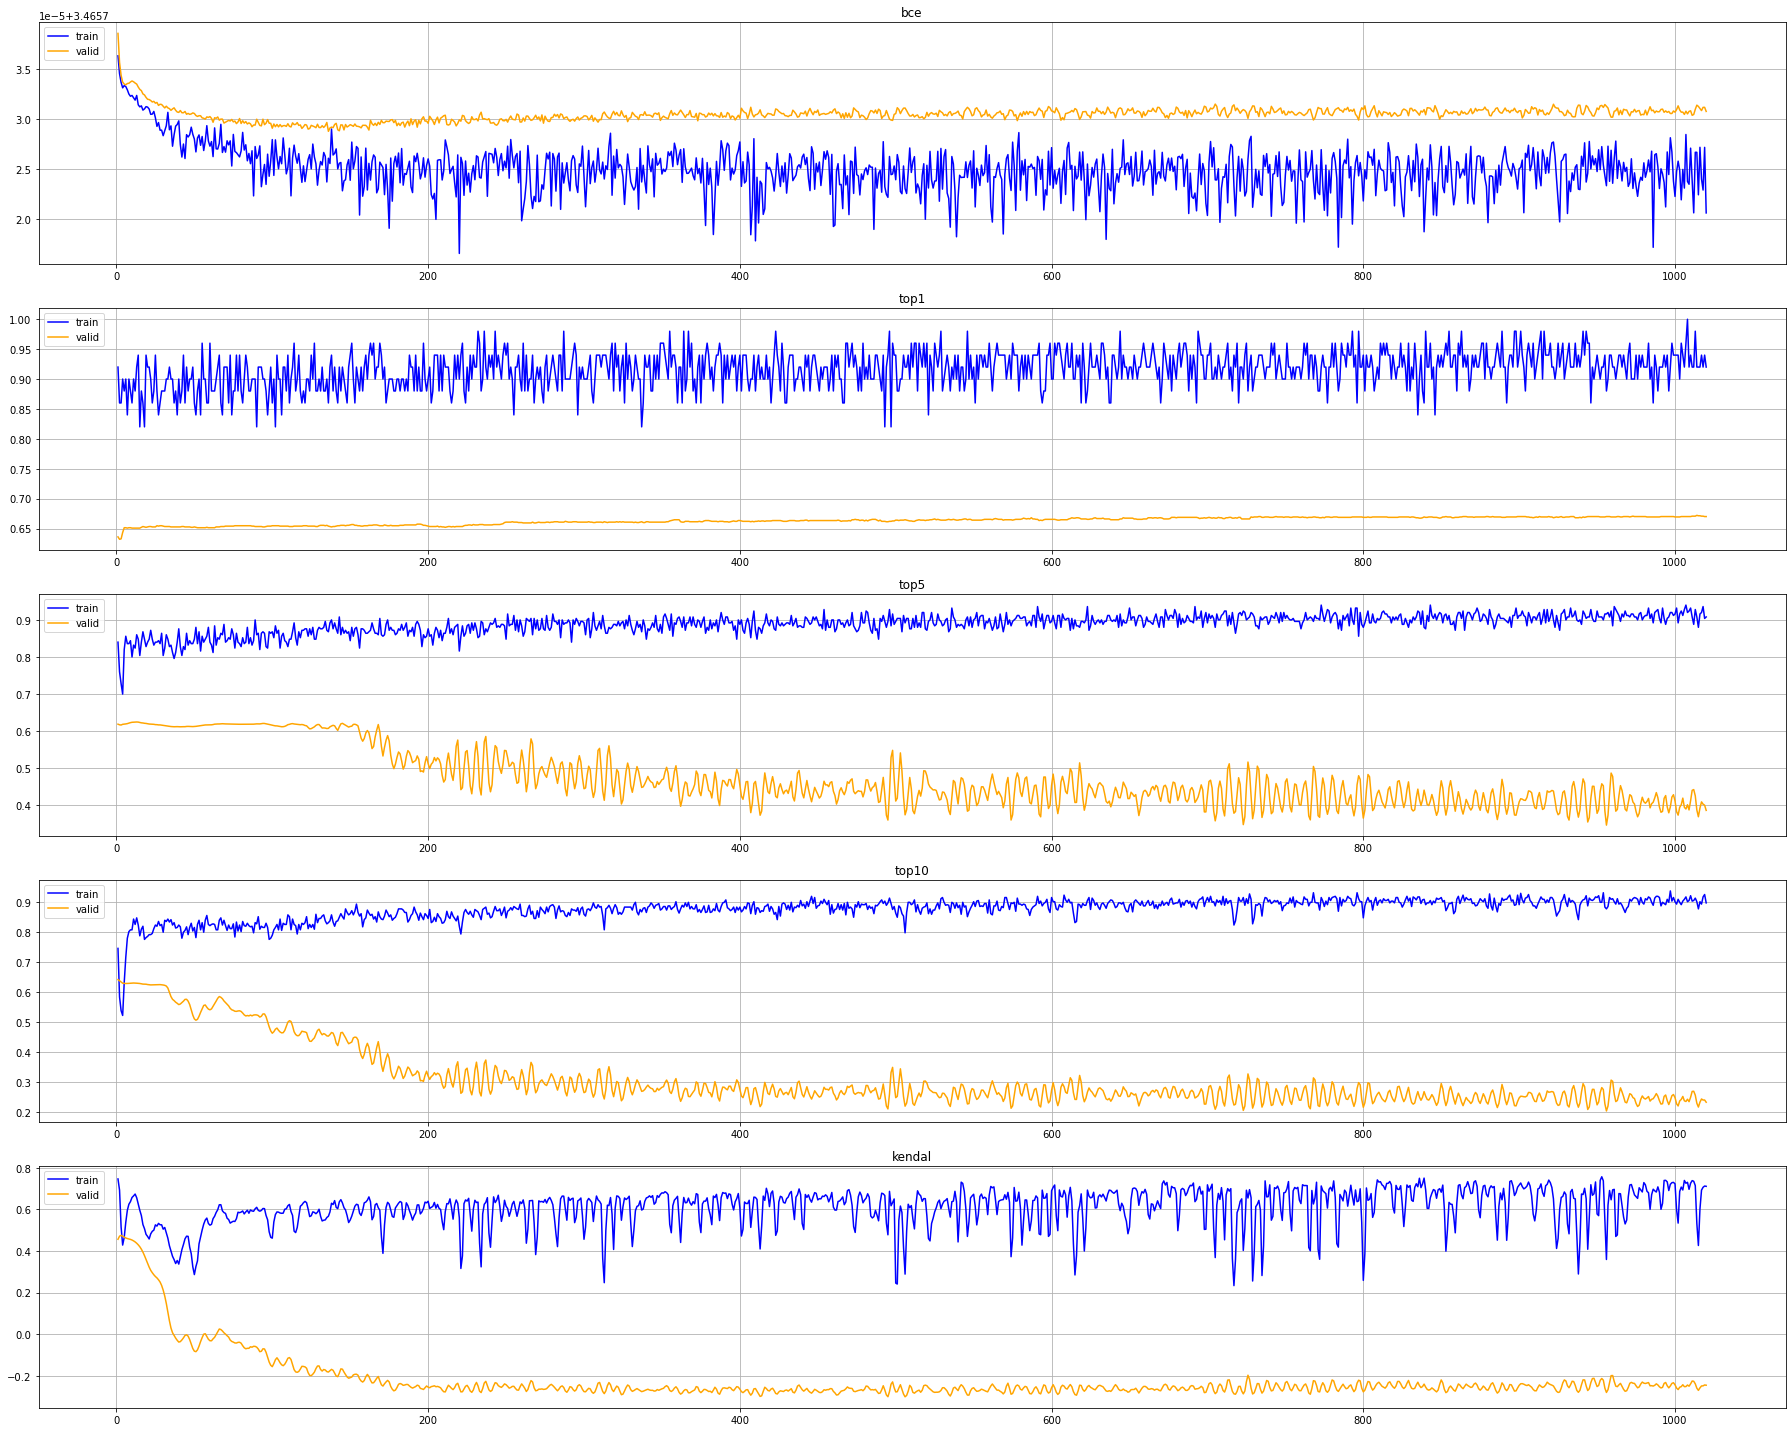

In [166]:
import matplotlib.pyplot as plt

with open(setting.train_info_p, 'r') as train_info, \
    open(setting.val_info_p, 'r') as valid_info:
    
    train = json.load(train_info)
    valid = json.load(valid_info)

    keys = list(train.keys())
    epochs = len(train[keys[0]])

    x = np.linspace(1, epochs, epochs)
    
    ### plot bce loss and mean top N %
    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        if key == "bce":
            y_train = [v/nodes_cnt for v in train[key]]
            y_valid = [v/5000 for v in valid[key]]
            ax.plot(x, y_train, color="blue")
            ax.plot(x, y_valid, color="orange")            
        else:
            ax.plot(x, train[key], color="blue")
            ax.plot(x, valid[key], color="orange")
        
        ax.legend(["train", "valid"], loc='upper left')
        ax.set_title(key)
        ax.grid()
        
    plt.tight_layout()
    plt.savefig(setting.result_plt_p, facecolor="white")

# Baseline

In [ ]:
import networkit as nk

In [ ]:
G = nk.readGraph("/hw1_data/Synthetic/5000/0.txt", nk.Format.EdgeListTabZero)

## RK (DIAM)

### ApproxBetweenness

Fast approximation of betweenness centrality through sampling.

In [ ]:
ab = nk.centrality.ApproxBetweenness(G, epsilon=0.1)
ab.run()

In [ ]:
# The 10 most central nodes according to betweenness are then 
ab.ranking()[:10]

## ABRA

Approximating betweenness centrality in static and dynamic graphs with rademacher averages

error tolerance λ to 0.01 and the probability δ to 0.1

## KADABRA

In [ ]:
# Initialize algorithm 
kadabra = nk.centrality.KadabraBetweenness(G, 0.05, 0.8) 
kadabra.run() 

In [ ]:
#The 10 most central nodes according to betweenness are then 
kadabra.ranking()[:10]

## K-BC (KPATH)

k-centralities: Local approximations of global measures based on shortest paths

In [ ]:
def KbcBetweenness(G):
    start = time.clock()
    kBC = dict({key:0 for key in G.nodes()})
    for s in G.nodes():
        #Structures
        Q = deque() #Queue
        S = deque() #Stack
        dist = dict({key:inf for key in G.nodes()})
        sig = dict({key:float(0) for key in G.nodes()})
        pred = dict({key:[] for key in G.nodes()})

        #Initialize
        Q.append(s)
        dist[s] = 0
        sig[s] = 1

        #BFS - top-down
        while len(Q) > 0:
            v = Q.popleft()
            if dist[v] > k:
                break;
            S.append(v)
            for w in G[v]:
                if dist[w] == inf:
                    dist[w] = dist[v] + 1
                    if dist[w] <= k:
                        Q.append(w)
                if dist[w] == dist[v] + 1:
                    sig[w] += sig[v]
                    pred[w].append(v)
        #Aggregate - bottom-up
        delta = dict({key:float(0) for key in G.nodes()})
        while len(S) > 0:
            v = S.pop()
            for w in pred[v]:
                delta[w] += (delta[v]+1) * sig[w] / sig[v]
            if v!=s:
                if(G.is_directed()):
                    kBC[v] += delta[v]
                else: kBC[v] += delta[v] / 2.0
    end = time.clock()
    print('My time: ' + str(end - start))